### This notebook shows an example of using GAN to generate images

Source: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

In [1]:
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
import tensorflow as tf
from keras.datasets import fashion_mnist
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
import keras.optimizers 
from matplotlib import pyplot
import numpy as np
from math import sqrt

### Using the [fashion_mnist](https://www.tensorflow.org/datasets/catalog/fashion_mnist) dataset

In [2]:

(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

4422102/4422102 [==============================] - 1s 0us/step
(60000, 28, 28, 1)


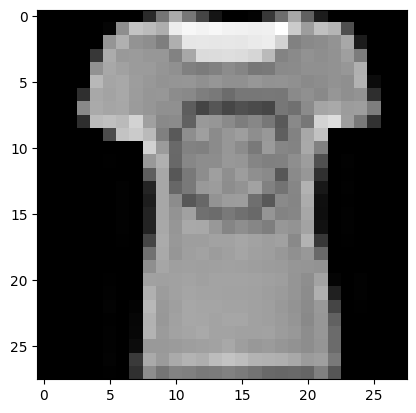

In [3]:
pyplot.imshow(X_train[441], cmap='gray')

In [75]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)  
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [76]:
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples) 
    X = X_train[ix]  
    y = ones((n_samples, 1)) 
    return X, y

In [77]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)  
    y = zeros((n_samples, 1))
    return images, y

In [78]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'mnist_model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))

In [79]:
from math import sqrt

def save_plot(examples, n_examples):
    for i in range(n_examples):
        pyplot.subplot(int(sqrt(n_examples)), int(sqrt(n_examples)), 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

In [80]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)  
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [81]:
discriminator = define_discriminator()

In [82]:
def define_generator(latent_dim): 
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,)) 
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model

In [83]:
generator = define_generator(100)

In [84]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [85]:
gan_model = define_gan(generator, discriminator)

In [86]:
def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs=10, n_batch=128):
    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    print("bat_per_epo", bat_per_epo, n_steps)
    for i in range(n_steps):
        X_real, y_real = generate_real_samples(X_train, n_batch)
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)
        z_input = generate_latent_points(latent_dim, n_batch) 
        y_gan = ones((n_batch, 1)) 
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
        if (i+1) % (bat_per_epo * 1) == 0:
            print("call summarize_performance ")
            summarize_performance(i, g_model, latent_dim)## This function saves the model for later use, as the training will take up some time
      
    return g_model

bat_per_epo 468 4680
4/4 [==============================] - 0s 3ms/step
>1, dr[0.008,1.000], df[0.689,0.789], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>2, dr[0.007,1.000], df[0.678,0.977], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>3, dr[0.005,1.000], df[0.668,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>4, dr[0.005,1.000], df[0.653,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>5, dr[0.006,1.000], df[0.640,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>6, dr[0.003,1.000], df[0.622,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>7, dr[0.006,1.000], df[0.609,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 2ms/step
>8, dr[0.004,1.000], df[0.586,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>9, dr[0.004,1.000], df[0.562,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3

>Saved: mnist_model_0468.h5
4/4 [==============================] - 0s 3ms/step
>469, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>470, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>471, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>472, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>473, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>474, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>475, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>476, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>477, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [=============

>Saved: mnist_model_0936.h5
4/4 [==============================] - 0s 5ms/step
>937, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>938, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>939, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>940, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>941, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>942, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>943, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>944, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>945, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [=============

>Saved: mnist_model_1404.h5
4/4 [==============================] - 0s 4ms/step
>1405, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>1406, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>1407, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>1408, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>1409, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 6ms/step
>1410, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 5ms/step
>1411, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>1412, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>1413, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [====

>Saved: mnist_model_1872.h5
4/4 [==============================] - 0s 3ms/step
>1873, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>1874, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>1875, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>1876, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>1877, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>1878, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>1879, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>1880, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>1881, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [====

>Saved: mnist_model_2340.h5
4/4 [==============================] - 0s 3ms/step
>2341, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>2342, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>2343, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>2344, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>2345, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>2346, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>2347, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>2348, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>2349, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [====

>Saved: mnist_model_2808.h5
4/4 [==============================] - 0s 6ms/step
>2809, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>2810, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>2811, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>2812, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>2813, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>2814, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>2815, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>2816, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>2817, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [====

>Saved: mnist_model_3276.h5
4/4 [==============================] - 0s 4ms/step
>3277, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>3278, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>3279, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>3280, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>3281, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>3282, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 5ms/step
>3283, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>3284, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 5ms/step
>3285, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [====

>Saved: mnist_model_3744.h5
4/4 [==============================] - 0s 3ms/step
>3745, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>3746, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>3747, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 5ms/step
>3748, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>3749, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>3750, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>3751, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 2ms/step
>3752, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 2ms/step
>3753, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [====

>Saved: mnist_model_4212.h5
4/4 [==============================] - 0s 3ms/step
>4213, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>4214, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>4215, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 5ms/step
>4216, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>4217, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>4218, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 3ms/step
>4219, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 4ms/step
>4220, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [==============================] - 0s 5ms/step
>4221, dr[0.000,1.000], df[0.000,1.000], g[0.000,1.000]
4/4 [====

>Saved: mnist_model_4680.h5


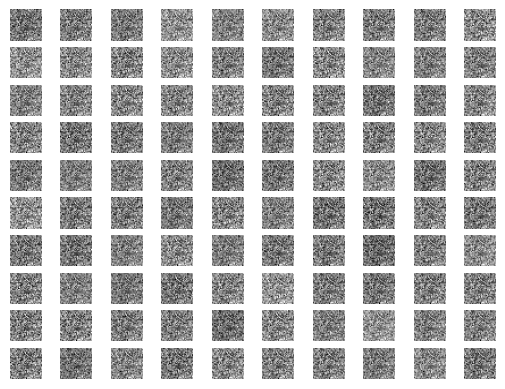

In [44]:
latent_dim = 100
gan = train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=10, n_batch=128)

1/1 [==============================] - 0s 84ms/step


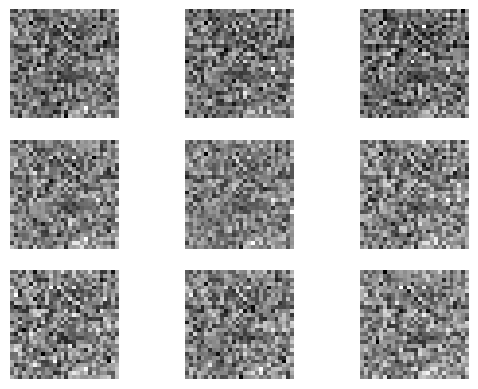

In [54]:
gan = load_model('/content/mnist_model_4680.h5')## Loading the saved model if used later
latent_dim = 100
n_examples = 9
latent_points = generate_latent_points(latent_dim, n_examples)
X  = gan.predict(latent_points)
X = (X + 1) / 2.0
n_examples = round(n_examples)
save_plot(X, n_examples)

## Lab 4
### Use this code to generate handwritten digits using the mnist dataset
#### The mnist dataset is available under keras.datasets

In [74]:
(X_train, _), (_, _) = keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

(60000, 28, 28, 1)


bat_per_epo 468 7020
4/4 [==============================] - 0s 5ms/step
>1, dr[0.372,0.812], df[0.279,0.938], g[2.274,0.047]
4/4 [==============================] - 0s 4ms/step
>2, dr[0.504,0.742], df[0.332,0.875], g[2.028,0.086]
4/4 [==============================] - 0s 3ms/step
>3, dr[0.322,0.836], df[0.439,0.836], g[2.186,0.039]
4/4 [==============================] - 0s 4ms/step
>4, dr[0.606,0.664], df[0.366,0.883], g[1.914,0.062]
4/4 [==============================] - 0s 4ms/step
>5, dr[0.350,0.836], df[0.517,0.797], g[2.176,0.031]
4/4 [==============================] - 0s 4ms/step
>6, dr[0.461,0.719], df[0.333,0.914], g[2.150,0.031]
4/4 [==============================] - 0s 5ms/step
>7, dr[0.538,0.703], df[0.422,0.867], g[2.047,0.031]
4/4 [==============================] - 0s 3ms/step
>8, dr[0.467,0.758], df[0.397,0.844], g[1.885,0.086]
4/4 [==============================] - 0s 3ms/step
>9, dr[0.328,0.836], df[0.396,0.836], g[2.034,0.062]
4/4 [==============================] - 0s 3

>Saved: mnist_model_0468.h5
4/4 [==============================] - 0s 3ms/step
>469, dr[0.573,0.672], df[0.414,0.859], g[1.843,0.047]
4/4 [==============================] - 0s 2ms/step
>470, dr[0.530,0.719], df[0.376,0.883], g[1.560,0.078]
4/4 [==============================] - 0s 2ms/step
>471, dr[0.517,0.688], df[0.503,0.812], g[1.555,0.086]
4/4 [==============================] - 0s 3ms/step
>472, dr[0.314,0.836], df[0.432,0.836], g[1.716,0.047]
4/4 [==============================] - 0s 3ms/step
>473, dr[0.504,0.727], df[0.467,0.789], g[1.771,0.086]
4/4 [==============================] - 0s 3ms/step
>474, dr[0.499,0.719], df[0.452,0.812], g[1.878,0.070]
4/4 [==============================] - 0s 3ms/step
>475, dr[0.567,0.648], df[0.422,0.859], g[1.614,0.094]
4/4 [==============================] - 0s 3ms/step
>476, dr[0.546,0.727], df[0.588,0.766], g[1.710,0.070]
4/4 [==============================] - 0s 4ms/step
>477, dr[0.480,0.703], df[0.440,0.820], g[1.733,0.062]
4/4 [=============

>Saved: mnist_model_0936.h5
4/4 [==============================] - 0s 3ms/step
>937, dr[0.617,0.617], df[0.503,0.797], g[1.576,0.086]
4/4 [==============================] - 0s 3ms/step
>938, dr[0.404,0.781], df[0.561,0.797], g[1.629,0.070]
4/4 [==============================] - 0s 3ms/step
>939, dr[0.533,0.711], df[0.417,0.844], g[1.711,0.055]
4/4 [==============================] - 0s 2ms/step
>940, dr[0.591,0.641], df[0.514,0.805], g[1.656,0.070]
4/4 [==============================] - 0s 3ms/step
>941, dr[0.540,0.688], df[0.545,0.844], g[1.747,0.070]
4/4 [==============================] - 0s 3ms/step
>942, dr[0.605,0.672], df[0.383,0.875], g[1.685,0.070]
4/4 [==============================] - 0s 3ms/step
>943, dr[0.468,0.734], df[0.435,0.875], g[1.543,0.070]
4/4 [==============================] - 0s 3ms/step
>944, dr[0.479,0.758], df[0.529,0.820], g[1.662,0.086]
4/4 [==============================] - 0s 4ms/step
>945, dr[0.459,0.758], df[0.427,0.867], g[1.631,0.070]
4/4 [=============

>Saved: mnist_model_1404.h5
4/4 [==============================] - 0s 3ms/step
>1405, dr[0.570,0.648], df[0.531,0.797], g[1.623,0.070]
4/4 [==============================] - 0s 3ms/step
>1406, dr[0.513,0.695], df[0.490,0.789], g[1.665,0.094]
4/4 [==============================] - 0s 3ms/step
>1407, dr[0.505,0.688], df[0.459,0.867], g[1.706,0.078]
4/4 [==============================] - 0s 3ms/step
>1408, dr[0.581,0.617], df[0.458,0.828], g[1.613,0.062]
4/4 [==============================] - 0s 3ms/step
>1409, dr[0.517,0.711], df[0.398,0.883], g[1.555,0.086]
4/4 [==============================] - 0s 4ms/step
>1410, dr[0.528,0.719], df[0.523,0.797], g[1.504,0.117]
4/4 [==============================] - 0s 5ms/step
>1411, dr[0.484,0.703], df[0.527,0.766], g[1.486,0.094]
4/4 [==============================] - 0s 6ms/step
>1412, dr[0.379,0.789], df[0.433,0.844], g[1.568,0.094]
4/4 [==============================] - 0s 3ms/step
>1413, dr[0.594,0.617], df[0.545,0.797], g[1.565,0.055]
4/4 [====

>Saved: mnist_model_1872.h5
4/4 [==============================] - 0s 3ms/step
>1873, dr[0.493,0.695], df[0.486,0.852], g[1.571,0.094]
4/4 [==============================] - 0s 3ms/step
>1874, dr[0.577,0.633], df[0.468,0.852], g[1.572,0.109]
4/4 [==============================] - 0s 4ms/step
>1875, dr[0.632,0.586], df[0.435,0.836], g[1.494,0.078]
4/4 [==============================] - 0s 3ms/step
>1876, dr[0.458,0.727], df[0.580,0.758], g[1.544,0.133]
4/4 [==============================] - 0s 3ms/step
>1877, dr[0.498,0.719], df[0.465,0.844], g[1.561,0.086]
4/4 [==============================] - 0s 4ms/step
>1878, dr[0.529,0.680], df[0.428,0.828], g[1.546,0.094]
4/4 [==============================] - 0s 3ms/step
>1879, dr[0.597,0.641], df[0.466,0.797], g[1.520,0.117]
4/4 [==============================] - 0s 3ms/step
>1880, dr[0.631,0.625], df[0.531,0.742], g[1.491,0.086]
4/4 [==============================] - 0s 3ms/step
>1881, dr[0.515,0.711], df[0.550,0.852], g[1.360,0.141]
4/4 [====

>Saved: mnist_model_2340.h5
4/4 [==============================] - 0s 4ms/step
>2341, dr[0.458,0.750], df[0.460,0.812], g[1.522,0.078]
4/4 [==============================] - 0s 3ms/step
>2342, dr[0.440,0.766], df[0.507,0.797], g[1.667,0.078]
4/4 [==============================] - 0s 3ms/step
>2343, dr[0.552,0.703], df[0.440,0.836], g[1.681,0.086]
4/4 [==============================] - 0s 4ms/step
>2344, dr[0.519,0.711], df[0.422,0.867], g[1.564,0.117]
4/4 [==============================] - 0s 4ms/step
>2345, dr[0.546,0.672], df[0.477,0.789], g[1.519,0.156]
4/4 [==============================] - 0s 4ms/step
>2346, dr[0.436,0.742], df[0.502,0.781], g[1.606,0.078]
4/4 [==============================] - 0s 5ms/step
>2347, dr[0.461,0.750], df[0.459,0.828], g[1.616,0.094]
4/4 [==============================] - 0s 4ms/step
>2348, dr[0.500,0.695], df[0.400,0.891], g[1.701,0.078]
4/4 [==============================] - 0s 4ms/step
>2349, dr[0.435,0.750], df[0.571,0.742], g[1.671,0.031]
4/4 [====

>Saved: mnist_model_2808.h5
4/4 [==============================] - 0s 4ms/step
>2809, dr[0.535,0.695], df[0.509,0.742], g[1.594,0.086]
4/4 [==============================] - 0s 3ms/step
>2810, dr[0.572,0.711], df[0.475,0.820], g[1.580,0.102]
4/4 [==============================] - 0s 4ms/step
>2811, dr[0.518,0.680], df[0.571,0.766], g[1.838,0.047]
4/4 [==============================] - 0s 4ms/step
>2812, dr[0.584,0.648], df[0.440,0.828], g[1.557,0.078]
4/4 [==============================] - 0s 3ms/step
>2813, dr[0.404,0.812], df[0.426,0.844], g[1.662,0.078]
4/4 [==============================] - 0s 3ms/step
>2814, dr[0.546,0.703], df[0.436,0.859], g[1.545,0.117]
4/4 [==============================] - 0s 4ms/step
>2815, dr[0.413,0.773], df[0.530,0.758], g[1.694,0.062]
4/4 [==============================] - 0s 3ms/step
>2816, dr[0.556,0.664], df[0.402,0.859], g[1.654,0.070]
4/4 [==============================] - 0s 3ms/step
>2817, dr[0.608,0.656], df[0.546,0.727], g[1.602,0.109]
4/4 [====

>Saved: mnist_model_3276.h5
4/4 [==============================] - 0s 4ms/step
>3277, dr[0.458,0.711], df[0.438,0.828], g[1.805,0.055]
4/4 [==============================] - 0s 4ms/step
>3278, dr[0.506,0.695], df[0.452,0.836], g[1.584,0.055]
4/4 [==============================] - 0s 4ms/step
>3279, dr[0.354,0.812], df[0.489,0.789], g[1.754,0.078]
4/4 [==============================] - 0s 4ms/step
>3280, dr[0.473,0.734], df[0.477,0.828], g[1.776,0.086]
4/4 [==============================] - 0s 3ms/step
>3281, dr[0.484,0.742], df[0.380,0.875], g[1.618,0.094]
4/4 [==============================] - 0s 3ms/step
>3282, dr[0.547,0.703], df[0.460,0.812], g[1.628,0.070]
4/4 [==============================] - 0s 3ms/step
>3283, dr[0.511,0.719], df[0.480,0.797], g[1.567,0.133]
4/4 [==============================] - 0s 3ms/step
>3284, dr[0.504,0.695], df[0.591,0.695], g[1.702,0.055]
4/4 [==============================] - 0s 3ms/step
>3285, dr[0.507,0.680], df[0.466,0.820], g[1.669,0.086]
4/4 [====

>Saved: mnist_model_3744.h5
4/4 [==============================] - 0s 3ms/step
>3745, dr[0.432,0.797], df[0.506,0.812], g[2.184,0.039]
4/4 [==============================] - 0s 3ms/step
>3746, dr[0.540,0.688], df[0.488,0.797], g[1.619,0.109]
4/4 [==============================] - 0s 3ms/step
>3747, dr[0.449,0.742], df[0.429,0.812], g[1.789,0.055]
4/4 [==============================] - 0s 4ms/step
>3748, dr[0.523,0.695], df[0.371,0.898], g[1.952,0.078]
4/4 [==============================] - 0s 4ms/step
>3749, dr[0.480,0.766], df[0.434,0.828], g[1.646,0.117]
4/4 [==============================] - 0s 5ms/step
>3750, dr[0.457,0.773], df[0.478,0.805], g[1.754,0.117]
4/4 [==============================] - 0s 4ms/step
>3751, dr[0.464,0.727], df[0.330,0.914], g[1.854,0.062]
4/4 [==============================] - 0s 3ms/step
>3752, dr[0.390,0.812], df[0.534,0.797], g[1.592,0.125]
4/4 [==============================] - 0s 3ms/step
>3753, dr[0.446,0.742], df[0.380,0.852], g[1.864,0.094]
4/4 [====

>Saved: mnist_model_4212.h5
4/4 [==============================] - 0s 4ms/step
>4213, dr[0.486,0.711], df[0.376,0.875], g[1.629,0.086]
4/4 [==============================] - 0s 2ms/step
>4214, dr[0.492,0.711], df[0.443,0.828], g[1.668,0.094]
4/4 [==============================] - 0s 3ms/step
>4215, dr[0.466,0.727], df[0.464,0.781], g[1.708,0.062]
4/4 [==============================] - 0s 2ms/step
>4216, dr[0.502,0.742], df[0.481,0.844], g[1.854,0.055]
4/4 [==============================] - 0s 3ms/step
>4217, dr[0.528,0.688], df[0.481,0.789], g[1.604,0.117]
4/4 [==============================] - 0s 5ms/step
>4218, dr[0.464,0.719], df[0.494,0.812], g[1.647,0.109]
4/4 [==============================] - 0s 4ms/step
>4219, dr[0.428,0.797], df[0.424,0.852], g[1.738,0.086]
4/4 [==============================] - 0s 3ms/step
>4220, dr[0.402,0.773], df[0.470,0.773], g[1.837,0.078]
4/4 [==============================] - 0s 3ms/step
>4221, dr[0.437,0.766], df[0.429,0.852], g[1.702,0.125]
4/4 [====

>Saved: mnist_model_4680.h5
4/4 [==============================] - 0s 4ms/step
>4681, dr[0.508,0.758], df[0.422,0.836], g[1.663,0.102]
4/4 [==============================] - 0s 4ms/step
>4682, dr[0.500,0.727], df[0.452,0.805], g[1.525,0.141]
4/4 [==============================] - 0s 3ms/step
>4683, dr[0.333,0.836], df[0.498,0.789], g[1.895,0.062]
4/4 [==============================] - 0s 3ms/step
>4684, dr[0.457,0.781], df[0.360,0.875], g[1.692,0.102]
4/4 [==============================] - 0s 5ms/step
>4685, dr[0.536,0.711], df[0.550,0.758], g[1.850,0.055]
4/4 [==============================] - 0s 3ms/step
>4686, dr[0.482,0.703], df[0.459,0.852], g[1.824,0.062]
4/4 [==============================] - 0s 3ms/step
>4687, dr[0.515,0.719], df[0.402,0.859], g[1.744,0.062]
4/4 [==============================] - 0s 4ms/step
>4688, dr[0.476,0.719], df[0.482,0.781], g[1.760,0.102]
4/4 [==============================] - 0s 5ms/step
>4689, dr[0.466,0.734], df[0.472,0.805], g[1.612,0.117]
4/4 [====

>Saved: mnist_model_5148.h5
4/4 [==============================] - 0s 3ms/step
>5149, dr[0.548,0.703], df[0.423,0.820], g[1.732,0.094]
4/4 [==============================] - 0s 5ms/step
>5150, dr[0.399,0.820], df[0.451,0.797], g[1.882,0.031]
4/4 [==============================] - 0s 3ms/step
>5151, dr[0.510,0.727], df[0.348,0.891], g[1.724,0.109]
4/4 [==============================] - 0s 3ms/step
>5152, dr[0.386,0.789], df[0.442,0.805], g[1.920,0.078]
4/4 [==============================] - 0s 2ms/step
>5153, dr[0.444,0.766], df[0.525,0.812], g[1.878,0.070]
4/4 [==============================] - 0s 5ms/step
>5154, dr[0.555,0.719], df[0.374,0.883], g[1.890,0.094]
4/4 [==============================] - 0s 4ms/step
>5155, dr[0.496,0.727], df[0.402,0.891], g[1.803,0.078]
4/4 [==============================] - 0s 3ms/step
>5156, dr[0.399,0.773], df[0.376,0.883], g[1.605,0.094]
4/4 [==============================] - 0s 4ms/step
>5157, dr[0.439,0.781], df[0.456,0.797], g[1.733,0.055]
4/4 [====

>Saved: mnist_model_5616.h5
4/4 [==============================] - 0s 2ms/step
>5617, dr[0.495,0.711], df[0.532,0.781], g[1.769,0.055]
4/4 [==============================] - 0s 5ms/step
>5618, dr[0.576,0.672], df[0.395,0.867], g[1.565,0.109]
4/4 [==============================] - 0s 3ms/step
>5619, dr[0.450,0.734], df[0.445,0.812], g[1.529,0.133]
4/4 [==============================] - 0s 3ms/step
>5620, dr[0.422,0.758], df[0.516,0.812], g[1.731,0.047]
4/4 [==============================] - 0s 5ms/step
>5621, dr[0.457,0.781], df[0.491,0.852], g[1.705,0.070]
4/4 [==============================] - 0s 4ms/step
>5622, dr[0.527,0.672], df[0.419,0.836], g[1.778,0.070]
4/4 [==============================] - 0s 3ms/step
>5623, dr[0.439,0.773], df[0.600,0.766], g[1.597,0.156]
4/4 [==============================] - 0s 3ms/step
>5624, dr[0.428,0.758], df[0.540,0.797], g[1.955,0.102]
4/4 [==============================] - 0s 5ms/step
>5625, dr[0.512,0.727], df[0.386,0.836], g[1.967,0.047]
4/4 [====

>Saved: mnist_model_6084.h5
4/4 [==============================] - 0s 5ms/step
>6085, dr[0.474,0.750], df[0.405,0.867], g[1.554,0.125]
4/4 [==============================] - 0s 6ms/step
>6086, dr[0.457,0.750], df[0.514,0.734], g[1.663,0.086]
4/4 [==============================] - 0s 5ms/step
>6087, dr[0.556,0.727], df[0.454,0.812], g[1.621,0.133]
4/4 [==============================] - 0s 4ms/step
>6088, dr[0.490,0.727], df[0.448,0.852], g[1.770,0.055]
4/4 [==============================] - 0s 5ms/step
>6089, dr[0.541,0.672], df[0.523,0.742], g[1.596,0.156]
4/4 [==============================] - 0s 4ms/step
>6090, dr[0.420,0.773], df[0.407,0.820], g[1.783,0.102]
4/4 [==============================] - 0s 3ms/step
>6091, dr[0.439,0.820], df[0.432,0.867], g[1.689,0.055]
4/4 [==============================] - 0s 5ms/step
>6092, dr[0.433,0.789], df[0.392,0.852], g[1.668,0.109]
4/4 [==============================] - 0s 3ms/step
>6093, dr[0.453,0.766], df[0.480,0.789], g[1.630,0.148]
4/4 [====

>Saved: mnist_model_6552.h5
4/4 [==============================] - 0s 6ms/step
>6553, dr[0.488,0.766], df[0.554,0.836], g[1.895,0.047]
4/4 [==============================] - 0s 3ms/step
>6554, dr[0.531,0.672], df[0.470,0.852], g[1.715,0.094]
4/4 [==============================] - 0s 3ms/step
>6555, dr[0.423,0.820], df[0.523,0.789], g[1.641,0.133]
4/4 [==============================] - 0s 3ms/step
>6556, dr[0.521,0.688], df[0.373,0.859], g[2.255,0.039]
4/4 [==============================] - 0s 3ms/step
>6557, dr[0.567,0.641], df[0.448,0.812], g[1.702,0.086]
4/4 [==============================] - 0s 5ms/step
>6558, dr[0.460,0.742], df[0.442,0.766], g[1.800,0.086]
4/4 [==============================] - 0s 3ms/step
>6559, dr[0.451,0.742], df[0.396,0.852], g[1.587,0.156]
4/4 [==============================] - 0s 3ms/step
>6560, dr[0.393,0.773], df[0.568,0.719], g[1.633,0.109]
4/4 [==============================] - 0s 3ms/step
>6561, dr[0.426,0.766], df[0.524,0.766], g[1.750,0.109]
4/4 [====

>Saved: mnist_model_7020.h5


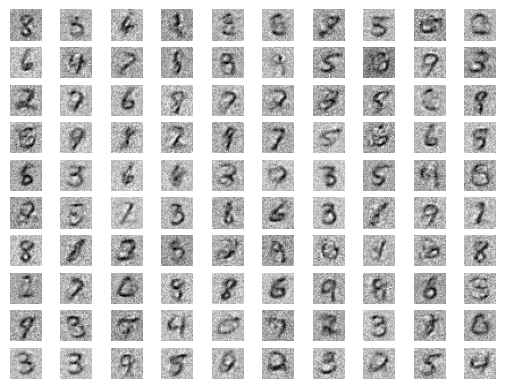

In [91]:
latent_dim = 100
gan = train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=15, n_batch=128)

2/2 [==============================] - 0s 5ms/step


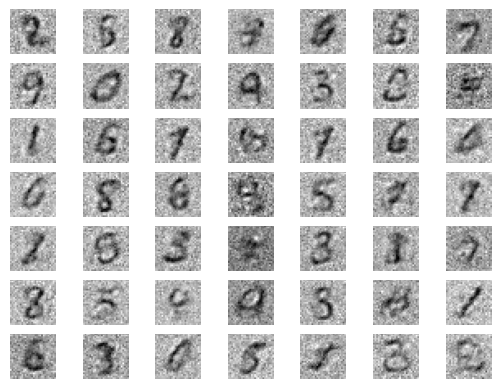

In [92]:
gan = load_model('/content/mnist_model_4680.h5')## Loading the saved model if used later
latent_dim = 100
n_examples = 49
latent_points = generate_latent_points(latent_dim, n_examples)
X  = gan.predict(latent_points)
X = (X + 1) / 2.0
n_examples = round(n_examples)
save_plot(X, n_examples)